# Cervical Notebook


## 1. Dependencies


In [1]:
import sys

sys.modules["IPython"] = None
sys.stderr = sys.stdout

import warnings

warnings.filterwarnings("ignore")

import os

os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
try:
    from pygad import GA
except:
    !pip3 install pygad==3.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [3]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    accuracy_score,
    RocCurveDisplay,
)

from xgboost import XGBClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from pygad import GA

from optuna import logging, create_study
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.exceptions import TrialPruned

logging.set_verbosity(logging.WARNING)

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

import shap

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
import textwrap

## 2. Data exploration


First, we will read the data.


In [4]:
df = pd.read_csv(
    "../input/cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv"
)

Then, we are going to check how is the data.


In [5]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

The names of some of the variables may not be determinative of what they specify. Therefore, by doing a little research we can come up with some articles that refer to this data set, detailing it a little more than in Kaggle's statement. Specifically, the url to the article is https://www.inescporto.pt/~jsc/publications/conferences/2017KelwinIBPRIA.pdf.

First, let's look at the table provided in the article.

| Feature                                       | Datatype    |
| --------------------------------------------- | ----------- |
| Age                                           | int         |
| Number of sexual partners                     | bool × int  |
| Age of first sexual intercourse               | bool × int  |
| Number of pregnancies                         | bool × int  |
| Smokes (yes/no)                               | bool × bool |
| Smokes (years and packs)                      | int × int   |
| Hormonal contraceptives (yes/no)              | bool        |
| Hormonal contraceptives (years)               | int         |
| Intrauterine device (IUD) (yes/no)            | bool        |
| IUD (years)                                   | int         |
| Sexually transmitted diseases (STDs) (yes/no) | bool × bool |
| Number of STDs                                | int         |
| Diagnosed STDs                                | Categorical |
| STDs (years since first diagnosis)            | int         |
| STDs (years last diagnosis)                   | int         |
| Previous cervical diagnosis (yes/no)          | bool        |
| Previous cervical diagnosis (years)           | int         |
| Previous cervical diagnosis                   | Categorical |

We can see that there are considerably fewer attributes than those indicated in the data set, so we will explain them one by one, although this is simply the nomenclature chosen by the authors.

- Age: Corresponds to `Age` in the data set, being of type integer.
- Number of sexual partners: Corresponds to `Number of sexual partners` in the data set, being of integer type as long as the patient has answered the question (this is what bool x bool refers to).
- Age of first sexual intercourse: Corresponds to `First sexual intercourse`, being of integer type.
- Number of pregnancies: Corresponds to `Num of pregnancies`, being of integer type.
- Smokes (yes/no): Corresponds to `Smokes`, being of boolean type.
- Smokes (years and packs): Corresponds to `Smokes (years)` and `Smokes (packs/year)` being the years and packages per year, both of float types.
- Hormonal contraceptives (yes/no): Corresponds to `Hormonal Contraceptives`, being of boolean type.
- Hormonal contraceptives (years): Corresponds to `Hormonal Contraceptives (years)`, being of float type.
- Intrauterine device (IUD) (yes/no): Corresponds to `IUD`, being of boolean type.
- IUD (years): Corresponds to `IUD (years)`, being of float type.
- Sexually transmitted diseases (STDs) (yes/no): Correspondos to `STDs`, being of boolean type.
- Number of STDs: Correspondos to `STDs (number)`, being of integer type.
- Diagnosed STDs: This is categorical type and corresponds to `STDs:condylomatosis`, `STDs:cervical condylomatosis`, `STDs:vaginal condylomatosis`, `STDs:vulvo-perineal condylomatosis`, `STDs:syphilis`, `STDs:pelvic inflammatory disease`, `STDs:genital herpes`, `STDs:molluscum contagiosum`, `STDs:AIDS`, `STDs:HIV`, `STDs:Hepatitis B`, `STDs:HPV`, all of them boolean type (one-hot encoding). Notice that the sum of all these attributes are equal to the previous one.
- STDs (years since first diagnosis): Corresponds to `STDs: Time since first diagnosis`, being of float type.
- STDs (years last diagnosis): Corresponds to `STDs: Time since last diagnosis`, being of float type. Noticce there are a third feature, `STDs: Number of diagnosis`, which indicates the number of diagnosis as integer. If its is zero, then both of previous attributes are going to be missing values, in case it's one, both are going to have the same value and if it's higher then first diagnosis is equal or lower than last diagnosis.
- Previous cervical diagnosis (yes/no): Corresponds to `Dx`, being of boolean type.
- Previous cervical diagnosis (years): Not in the data set provided.
- Previous cervical diagnosis: This is categorical type and corresponds to `Dx:Cancer`, `Dx:CIN`, `Dx:HPV`, all of them boolean type (one-hot encoding as well).

Therefore, of the 36 total attributes we have seen 32, the other 4 being target features:

- Hinselmann
- Schiller
- Citology
- Biopsy

These are tests performed to check for certain pathologies. For example, Shchiller and Hinselmann can indicate areas with abnormal cells, while the biopsy diagnoses whether these areas are a symptom of a malignant tumor or not. Normally, the order of the tests is usually (although it will depend on each patient) citology, Schiller, Hinselmann and finally biopsy.

Therefore, we are going to make biopsy the target because it is the most relevant due to its danger. In addition, we will add the other three attributes to the set of attributes to see how the performance behaves to detect whether there is cancer or not. Note that in the case of the article what is done is to take two tests, one being the target and the other added to the data set.

Let's check the correlation between these attributes, but first we will convert the missing values (?) into NaN to be able to handle it easily.


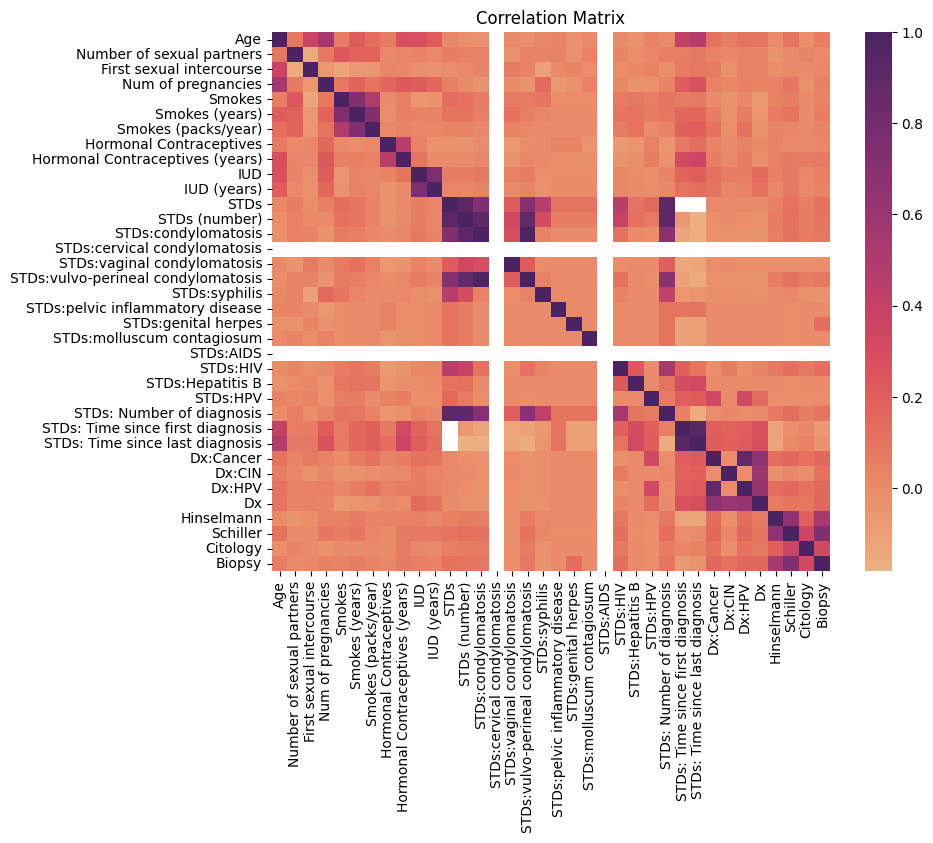

In [7]:
df = df.replace("?", np.nan)

plt.figure(figsize=(9, 7))
sns.heatmap(df.corr(), cmap="flare")
plt.title("Correlation Matrix")
plt.show()

We can confirm the above investigated how these four medical tests are related to each other, but not much to the rest of the attributes.

Let's also look at the distribution of the target attribute.


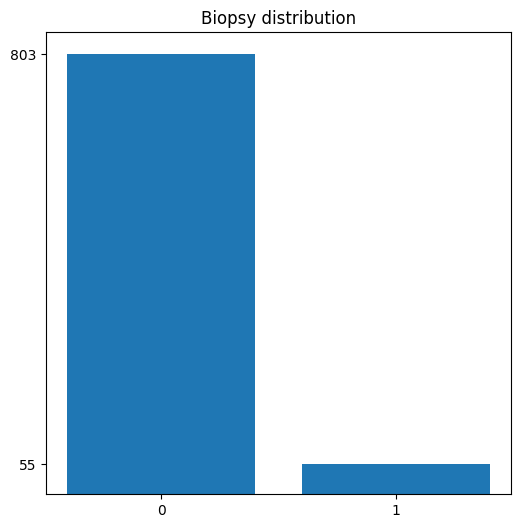

In [8]:
dist = df["Biopsy"].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(dist.index, dist.values)
plt.xticks(dist.index)
plt.yticks(dist.values)
plt.title("Biopsy distribution")
plt.show()

We can see how it is unbalanced, so we will have to take it into account later when choosing the performance metric.


## 3. Nulls treatment


Now we'll start with null treatment. Let's see how many nulls there are.


In [9]:
df.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

As the four targets have no nulls we separate them from the training attributes.


In [10]:
targets = ["Hinselmann", "Schiller", "Citology", "Biopsy"]

X = df.drop(targets, axis=1)
ys = df[targets]

First we will eliminate `STDs: Time since first diagnosis` and `STDs: Time since last diagnosis` columns because the vast majority of values are null and trying to fill them in would be almost arbitrary and would add noise to the data set.


In [11]:
X = X.drop(
    ["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"],
    axis=1,
)

Then we will solve those which are few per column, concretely, `Number of sexual partners`, `First sexual intercourse`, and `Num of pregnancies`. In all three cases we will take the most frequent value, since we have no other relevant information to fill them.


In [12]:
cols = [
    "Number of sexual partners",
    "First sexual intercourse",
    "Num of pregnancies",
]

X[cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[cols])

The next attributes with few nulls will be those related to smoking. In this case, all three are related to whether or not you smoke. We can check first if the 13 instances are the same or not.


In [13]:
idx = X[X["Smokes"].isnull()].index

cols = [
    "Smokes (years)",
    "Smokes (packs/year)",
]

X[cols].apply(lambda col: col[col.isnull()].index.equals(idx))

Smokes (years)         True
Smokes (packs/year)    True
dtype: bool

Once verified, let's look at their most common value, and based on that, we will assign the other two columns, to keep the data set consistent.


In [14]:
cols = [
    "Smokes",
]

SimpleImputer(strategy="most_frequent").fit(X[cols]).statistics_

array(['0.0'], dtype=object)

Since the mode of smoking or not smoking is 0, we will also assign zero to the other two columns.


In [15]:
cols = [
    "Smokes",
    "Smokes (years)",
    "Smokes (packs/year)",
]

X[cols] = SimpleImputer(strategy="constant", fill_value=0.0).fit_transform(X[cols])

Let's perform the same reasoning but for STDs.


In [16]:
idx = X[X["STDs"].isnull()].index

cols = [
    "STDs (number)",
    "STDs:condylomatosis",
    "STDs:cervical condylomatosis",
    "STDs:vaginal condylomatosis",
    "STDs:vulvo-perineal condylomatosis",
    "STDs:syphilis",
    "STDs:pelvic inflammatory disease",
    "STDs:genital herpes",
    "STDs:molluscum contagiosum",
    "STDs:AIDS",
    "STDs:HIV",
    "STDs:Hepatitis B",
    "STDs:HPV",
]

X[cols].apply(lambda col: col[col.isnull()].index.equals(idx))

STDs (number)                         True
STDs:condylomatosis                   True
STDs:cervical condylomatosis          True
STDs:vaginal condylomatosis           True
STDs:vulvo-perineal condylomatosis    True
STDs:syphilis                         True
STDs:pelvic inflammatory disease      True
STDs:genital herpes                   True
STDs:molluscum contagiosum            True
STDs:AIDS                             True
STDs:HIV                              True
STDs:Hepatitis B                      True
STDs:HPV                              True
dtype: bool

In [17]:
cols = [
    "STDs",
]

SimpleImputer(strategy="most_frequent").fit(X[cols]).statistics_

array(['0.0'], dtype=object)

Again, in general, there are no STDs, so zero will be assigned to all categories.


In [18]:
cols = [
    "STDs",
    "STDs (number)",
    "STDs:condylomatosis",
    "STDs:cervical condylomatosis",
    "STDs:vaginal condylomatosis",
    "STDs:vulvo-perineal condylomatosis",
    "STDs:syphilis",
    "STDs:pelvic inflammatory disease",
    "STDs:genital herpes",
    "STDs:molluscum contagiosum",
    "STDs:AIDS",
    "STDs:HIV",
    "STDs:Hepatitis B",
    "STDs:HPV",
]

X[cols] = SimpleImputer(strategy="constant", fill_value=0.0).fit_transform(X[cols])

Finally, instead of applying the same reasoning, as there are already few columns with nulls with respect to the total, we will apply a predictive imputation with KNNImputer.


In [19]:
X[:] = KNNImputer(n_neighbors=1).fit_transform(X)

In [20]:
X.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


## 4. Encoding and normalization


Once the null treatment is finished, we would have to encode the attributes to numeric, but since they are already all numeric, we will go directly to see if it is necessary to normalize or not. Note that if we only use tree-based models it would not be necessary, but this will not be the case.


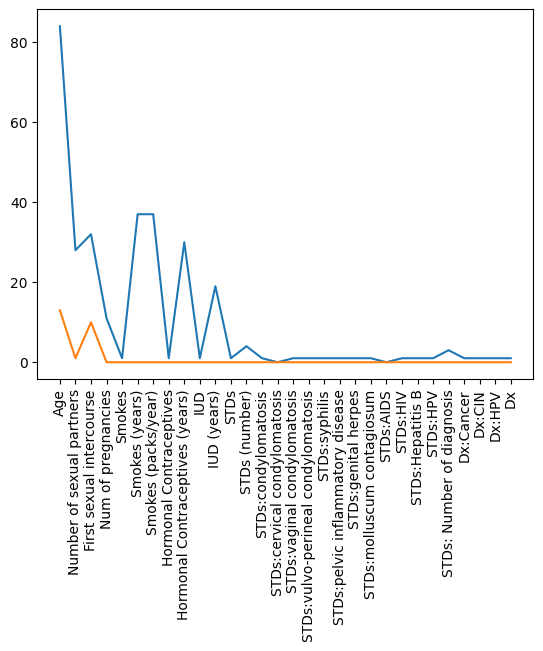

In [21]:
plt.plot(X.max())
plt.plot(X.min())
plt.xticks(ticks=range(X.columns.shape[0]), labels=X.columns, rotation=90)
plt.show()

We can see how there are disparate values, so normalization is necessary. We will use the standard scaler as it was the one that gave me the best results.


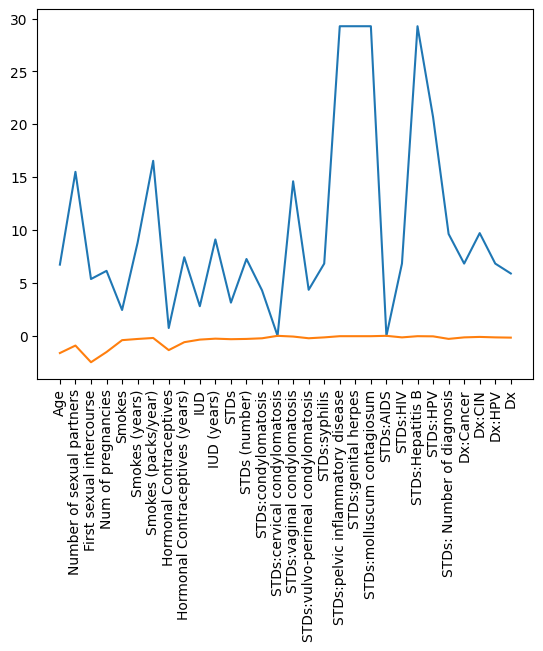

In [22]:
X = pd.DataFrame(
    StandardScaler().fit_transform(X),
    index=X.index,
    columns=X.columns,
)

plt.plot(X.max())
plt.plot(X.min())
plt.xticks(ticks=range(X.columns.shape[0]), labels=X.columns, rotation=90)
plt.show()

Once finished, we move on to evaluate the model without any type of optimization.


## 5. Classical approaches


## &#160;&#160;&#160;&#160;5.1. Model evaluation


To do this we will create an auxiliary function to display the results of the cross validation and the confusion matrix.

Some decisions taken:

- What are we going to evaluate? The metric should take into account the distribution imbalance discussed above. Therefore, for example, we could use balanced hit rate or f1, the first one being the one chosen by us.
- How are we going to evaluate? As it is a data set without time or groups, we can use the k-folds without any problem. Note that we will use the stratified version because of the skewness.

In addition, regarding the models used, we will use KNN, RandomForest and XGBoost, the latter two because they provide very good results in tabular data and KNN because we wanted to see the behavior in a more simple model.


In [23]:
def evaluate(models, X, y, cv, *, plot_cm=False):

    if plot_cm:
        _, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(len(models) * 6, 6))

    for i, model in enumerate(models):

        scores = cross_val_score(
            model,
            X,
            y,
            scoring="balanced_accuracy",
            cv=cv,
            n_jobs=-1,
        )

        print(f"Cross validation with {type(model).__name__}:", scores.mean())

        if plot_cm:

            y_tests, y_preds = [], []
            for train, test in cv.split(X, y):
                X_train, X_test, y_train, y_test = (
                    X.iloc[train],
                    X.iloc[test],
                    y.iloc[train],
                    y.iloc[test],
                )
                model.fit(X_train, y_train)
                y_tests.extend(y_test.values)
                y_preds.extend(model.predict(X_test))

            ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, ax=axes[i])
            axes[i].title.set_text(type(model).__name__)

    if plot_cm:
        plt.show()

First we choose the target mentioned above, as well as create the stratified separation.


In [24]:
y = ys["Biopsy"]

skf = StratifiedKFold(n_splits=10)

Cross validation with KNeighborsClassifier: 0.5986882716049383
Cross validation with RandomForestClassifier: 0.5
Cross validation with XGBClassifier: 0.5


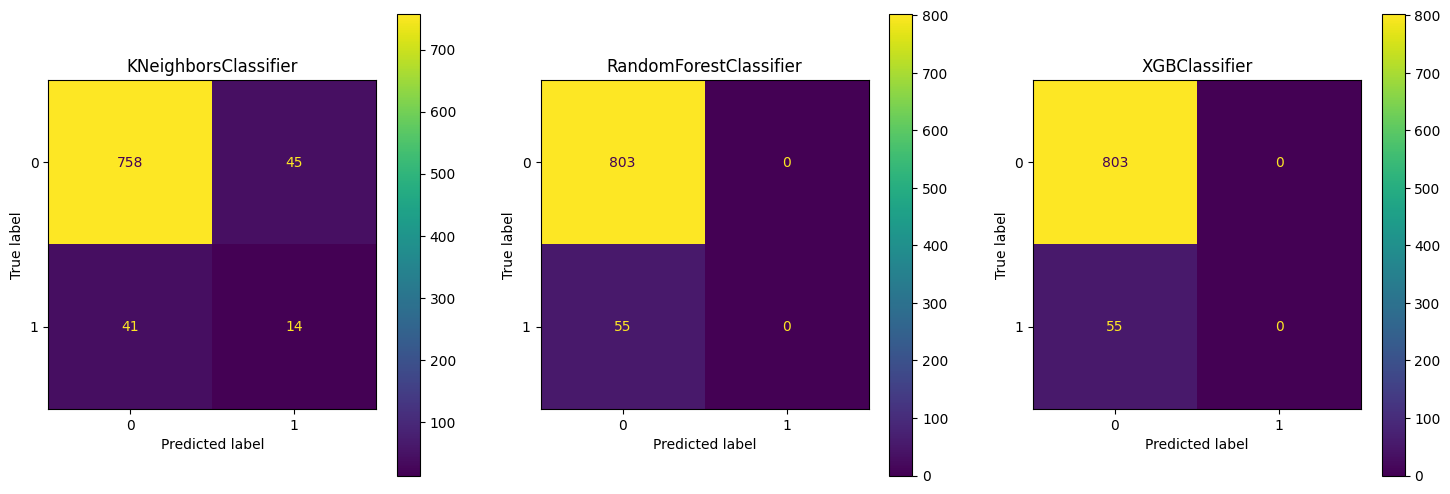

In [25]:
evaluate(
    (
        KNeighborsClassifier(
            n_neighbors=1,
            metric="cosine",
        ),
        RandomForestClassifier(
            n_estimators=20,
            max_depth=2,
            criterion="entropy",
        ),
        XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=10,
            max_depth=2,
        ),
    ),
    X,
    y,
    skf,
    plot_cm=True,
)

We can see how in the two tree-based models they decide to predict everything as negative, which, even if we have a 50% return, is very mediocre. On the other hand, we have that KNN did predict some instances as positive, which, as the performance is also better, for now this last model, despite being simpler, is better.

Let us now check the performance if we add some of the other tests to the attributes.


In [26]:
evaluate(
    (
        KNeighborsClassifier(
            n_neighbors=1,
            metric="cosine",
        ),
        RandomForestClassifier(
            n_estimators=20,
            max_depth=2,
            criterion="entropy",
        ),
        XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=10,
            max_depth=2,
        ),
    ),
    pd.concat((X, ys["Citology"]), axis=1),
    y,
    skf,
)

Cross validation with KNeighborsClassifier: 0.6440509259259259
Cross validation with RandomForestClassifier: 0.5
Cross validation with XGBClassifier: 0.5


In [27]:
evaluate(
    (
        KNeighborsClassifier(
            n_neighbors=1,
            metric="cosine",
        ),
        RandomForestClassifier(
            n_estimators=20,
            max_depth=2,
            criterion="entropy",
        ),
        XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=10,
            max_depth=2,
        ),
    ),
    pd.concat((X, ys["Schiller"]), axis=1),
    y,
    skf,
)

Cross validation with KNeighborsClassifier: 0.7340123456790123
Cross validation with RandomForestClassifier: 0.5
Cross validation with XGBClassifier: 0.6613040123456791


In [28]:
evaluate(
    (
        KNeighborsClassifier(
            n_neighbors=1,
            metric="cosine",
        ),
        RandomForestClassifier(
            n_estimators=20,
            max_depth=2,
            criterion="entropy",
        ),
        XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=10,
            max_depth=2,
        ),
    ),
    pd.concat((X, ys["Hinselmann"]), axis=1),
    y,
    skf,
)

Cross validation with KNeighborsClassifier: 0.6551003086419753
Cross validation with RandomForestClassifier: 0.5
Cross validation with XGBClassifier: 0.5804552469135802


We can see that in all three cases the performance has improved, the highest being Schiller, which is precisely the one that had the highest correlation with the biopsy seen at the beginning of the notebook.

Let's see the performance with the three attributes at the same time.


In [29]:
evaluate(
    (
        KNeighborsClassifier(
            n_neighbors=1,
            metric="cosine",
        ),
        RandomForestClassifier(
            n_estimators=20,
            max_depth=2,
            criterion="entropy",
        ),
        XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=10,
            max_depth=2,
        ),
    ),
    pd.concat((X, ys[["Hinselmann", "Schiller", "Citology"]]), axis=1),
    y,
    skf,
)

Cross validation with KNeighborsClassifier: 0.7073533950617285
Cross validation with RandomForestClassifier: 0.4993827160493828
Cross validation with XGBClassifier: 0.6369290123456791


We can see that the best overall result obtained among the three attributes is when only Schiller is added. Therefore, for this reason and because in reality not all the tests are usually performed before the biopsy (neither any), we are going to continue working with Schiller within the set of attributes.

In addition, this way we could compare results with the article referenced above, since, as mentioned, in this one they take one test to add to the attributes and see the performance on another as a target.


In [30]:
X = pd.concat((X, ys["Schiller"]), axis=1)

## &#160;&#160;&#160;&#160;5.2. Simple tuning


The next thing we are going to do is the feature selection, although before this we will perform a small optimization of hyperparameters so that the selection does not fall on those selected by trial and error. To do this, we will use grid search.


In [31]:
def simple_tuning(models, X, y, cv):

    for model, grid in models:

        search = GridSearchCV(
            model,
            grid,
            scoring="balanced_accuracy",
            cv=cv,
            n_jobs=-1,
        ).fit(X, y)

        output = (
            f"{type(model).__name__}: {search.best_score_} with {search.best_params_}"
        )

        print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

In [32]:
simple_tuning(
    [
        (
            KNeighborsClassifier(),
            {
                "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 21, 31, 51, 101],
                "weights": ["uniform", "distance"],
                "metric": ["euclidean", "manhattan", "cosine"],
            },
        ),
        (
            RandomForestClassifier(),
            {
                "n_estimators": [10, 30, 50, 100, 200],
                "criterion": ["gini", "entropy", "log_loss"],
                "max_depth": [2, 3, 4, 5, 6, 10, 20],
            },
        ),
        (
            XGBClassifier(),
            {
                "objective": ["binary:logistic"],
                "learning_rate": [0.01, 0.1, 0.2],
                "n_estimators": [50, 75, 150],
                "max_depth": [3, 5, 10],
            },
        ),
    ],
    X,
    y,
    skf,
)

KNeighborsClassifier: 0.7340123456790123 with {'metric': 'cosine', 'n_neighbors': 1,
	'weights': 'uniform'}
RandomForestClassifier: 0.7815046296296295 with {'criterion': 'gini', 'max_depth': 20,
	'n_estimators': 50}
XGBClassifier: 0.8181790123456791 with {'learning_rate': 0.1, 'max_depth': 3,
	'n_estimators': 50, 'objective': 'binary:logistic'}


The results obtained are (they may vary since there is no seed):

- KNeighborsClassifier: 0.7340123456790123 with {'metric': 'cosine', 'n_neighbors': 1, 'weights': 'uniform'}
- RandomForestClassifier: 0.7873302469135802 with {'criterion': 'log_loss', 'max_depth':10, 'n_estimators': 30}
- XGBClassifier: 0.8181790123456791 with {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'objective': 'binary:logistic'}

This optimization alone has improved the results even further. More in-depth comparisons will be made at a later date once all optimizations have been completed.


## &#160;&#160;&#160;&#160;5.3. Feature selection


After hyperparameter tuning, we proceed to attribute selection. Two methods will be used for this:

- For a more exhaustive search, SequentialForwardSelector
- For a more stochastic search, GeneticAlgorithms

The main method will be Sequential forward selection (SFS), in which features are sequentially added to an empty candidate set until the addition of more features does not lower the criterion.

We will use genetic algorithms to check with a small stochastic search if there is a possibility that there are other combinations that improve performance. This is because SequentialForwardSelector adds measures starting from one measure, i.e., it does not check all combinations and there may be a better one. Regarding the genetic algorithm itself, the fitness function will correspond to the cross-validation of a binary individual, where a 1 in position i will represent that measure i is taken for the evaluation, and if it is 0 it is not.


In [33]:
def feature_selection(models, X, y, cv):

    def fitness_func(ga_instance, individual, individual_idx):
        idx = [i for i in range(len(individual)) if individual[i] == 1]

        attributes = X.iloc[:, idx]
        objective = y

        if not attributes.empty:
            res = cross_val_score(
                estimator=model,
                X=attributes,
                y=objective,
                cv=cv,
                scoring="balanced_accuracy",
                n_jobs=-1,
            )

        return res.mean() if not attributes.empty else -10000

    for model in models:

        print(f"{type(model).__name__}:")

        # Sequential Forward Selector
        sfs = SFS(
            model,
            k_features=(1, len(X.columns)),
            scoring="balanced_accuracy",
            cv=cv,
            n_jobs=-1,
            floating=True,
        )
        sfs.fit(X, y)

        # Genetic Algorithms
        individual_size = X.shape[1]
        ga_instance = GA(
            num_generations=sys.maxsize,
            num_parents_mating=2,
            fitness_func=fitness_func,
            sol_per_pop=25,
            num_genes=individual_size,
            gene_type=int,
            init_range_low=0,
            init_range_high=2,
            parent_selection_type="rws",
            keep_parents=1,
            crossover_type="single_point",
            crossover_probability=0.3,
            mutation_type="random",
            mutation_probability=0.05,
            stop_criteria=["saturate_5"],
        )
        ga_instance.run()

        # SFS results
        output = "SFS: %.3f with %s == %s" % (
            sfs.k_score_,
            sfs.k_feature_idx_,
            sfs.k_feature_names_,
        )
        print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

        # GA results
        solution, solution_fitness, _ = ga_instance.best_solution()
        feature_idx = np.where(solution == 1)[0]
        feature_names = X.columns[feature_idx]
        output = "GA: %.3f with %s == %s" % (
            solution_fitness,
            tuple(feature_idx),
            tuple(feature_names),
        )
        print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

        # Graphic results
        plot_sfs(sfs.get_metric_dict(), kind="std_dev", figsize=(6, 4))
        plt.grid()
        plt.title(f"{type(model).__name__} Sequential Forward Selection (w. StdDev)")

    plt.show()

KNeighborsClassifier:
SFS: 0.932 with (4, 7, 14, 17, 19, 21, 23, 26, 30) == ('Smokes', 'Hormonal
	Contraceptives', 'STDs:cervical condylomatosis', 'STDs:syphilis', 'STDs:genital
	herpes', 'STDs:AIDS', 'STDs:Hepatitis B', 'Dx:Cancer', 'Schiller')
GA: 0.810 with (2, 3, 6, 15, 16, 17, 24, 26, 28, 30) == ('First sexual intercourse',
	'Num of pregnancies', 'Smokes (packs/year)', 'STDs:vaginal condylomatosis',
	'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:HPV', 'Dx:Cancer',
	'Dx:HPV', 'Schiller')
RandomForestClassifier:
SFS: 0.923 with (17, 30) == ('STDs:syphilis', 'Schiller')
GA: 0.866 with (3, 9, 12, 15, 18, 20, 28, 29, 30) == ('Num of pregnancies', 'IUD', 'STDs
	(number)', 'STDs:vaginal condylomatosis', 'STDs:pelvic inflammatory disease',
	'STDs:molluscum contagiosum', 'Dx:HPV', 'Dx', 'Schiller')
XGBClassifier:
SFS: 0.922 with (30,) == ('Schiller',)
GA: 0.898 with (3, 6, 7, 10, 14, 16, 17, 18, 19, 21, 22, 25, 29, 30) == ('Num of
	pregnancies', 'Smokes (packs/year)', 'Hormo

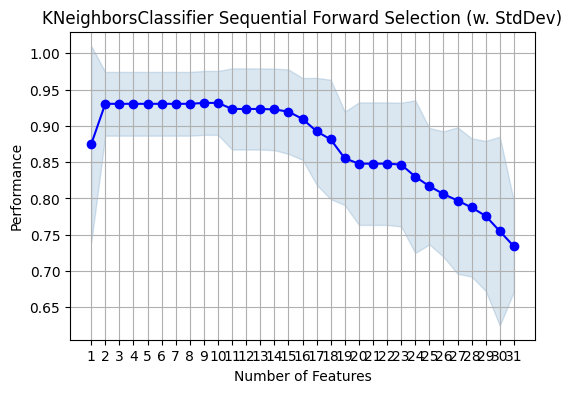

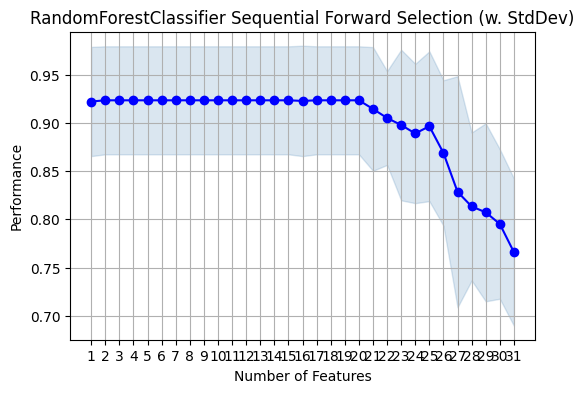

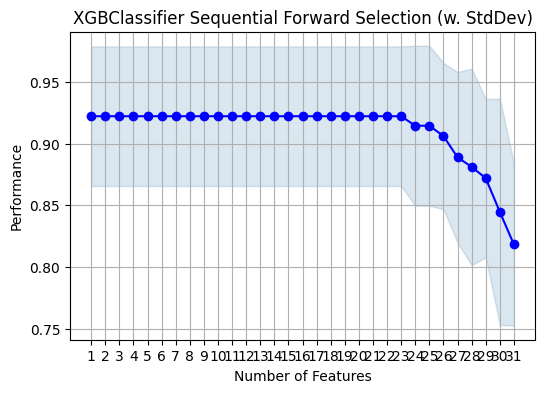

In [34]:
feature_selection(
    [
        KNeighborsClassifier(
            n_neighbors=1,
            metric="cosine",
            weights="uniform",
        ),
        RandomForestClassifier(
            criterion="log_loss",
            max_depth=10,
            n_estimators=30,
        ),
        XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=50,
            max_depth=3,
        ),
    ],
    X,
    y,
    skf,
)

The results obtained are:

- KNeighborsClassifier:
  - SFS: 0.932 with (4, 7, 14, 17, 19, 21, 23, 26, 30) == ('Smokes', 'Hormonal
    Contraceptives', 'STDs:cervical condylomatosis', 'STDs:syphilis', 'STDs:genital
    herpes', 'STDs:AIDS', 'STDs:Hepatitis B', 'Dx:Cancer', 'Schiller')
  - GA: 0.799 with (1, 2, 4, 5, 6, 12, 14, 20, 21, 22, 24, 25, 26, 29, 30) == ('Number of
    sexual partners', 'First sexual intercourse', 'Smokes', 'Smokes (years)', 'Smokes
    (packs/year)', 'STDs (number)', 'STDs:cervical condylomatosis', 'STDs:molluscum
    contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:HPV', 'STDs: Number of diagnosis',
    'Dx:Cancer', 'Dx', 'Schiller')
- RandomForestClassifier:
  - SFS: 0.924 with (3, 17, 30) == ('Num of pregnancies', 'STDs:syphilis', 'Schiller')
  - GA: 0.830 with (0, 3, 7, 10, 12, 15, 17, 27, 29, 30) == ('Age', 'Num of pregnancies',
    'Hormonal Contraceptives', 'IUD (years)', 'STDs (number)', 'STDs:vaginal
    condylomatosis', 'STDs:syphilis', 'Dx:CIN', 'Dx', 'Schiller')
- XGBClassifier:
  - SFS: 0.922 with (30,) == ('Schiller',)
  - GA: 0.914 with (1, 3, 7, 10, 14, 18, 20, 22, 23, 27, 30) == ('Number of sexual
    partners', 'Num of pregnancies', 'Hormonal Contraceptives', 'IUD (years)',
    'STDs:cervical condylomatosis', 'STDs:pelvic inflammatory disease', 'STDs:molluscum
    contagiosum', 'STDs:HIV', 'STDs:Hepatitis B', 'Dx:CIN', 'Schiller')

In all three cases, we have obtained the best result from SFS, which was expected. In addition, it was again significantly improved over the previous optimization.

We can also appreciate the evolution of adding attributes in the SFS. However, we cannot see which are the most relevant attributes (although the most important is probably Schiller) so we are going to see it with importance by permutation.


In [35]:
def feature_importance(models, X, y, cv):

    _, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(6, len(models) * 6))

    for i, (model, attributes) in enumerate(models):

        total_importances = None

        X_selected = X[attributes]

        for train, test in cv.split(X, y):
            X_train, X_test, y_train, y_test = (
                X_selected.iloc[train],
                X_selected.iloc[test],
                y.iloc[train],
                y.iloc[test],
            )

            model.fit(X_train, y_train)
            pi = permutation_importance(
                model,
                X_test,
                y_test,
                n_jobs=-1,
                scoring="balanced_accuracy",
                n_repeats=10,
            )
            importances = pi.importances

            if total_importances is None:
                total_importances = pi.importances
            else:
                total_importances = np.hstack((total_importances, importances))

        dfp = pd.DataFrame(data=total_importances.T, columns=X_selected.columns)
        meds = dfp.mean()
        meds.sort_values(ascending=True, inplace=True)
        dfp = dfp[meds.index]
        dfp.boxplot(vert=False, ax=axes[i])
        axes[i].title.set_text(f"{type(model).__name__} Permutation Importance")
        axes[i].set_xlabel("Importance")
        axes[i].set_ylabel("Features")

    plt.show()

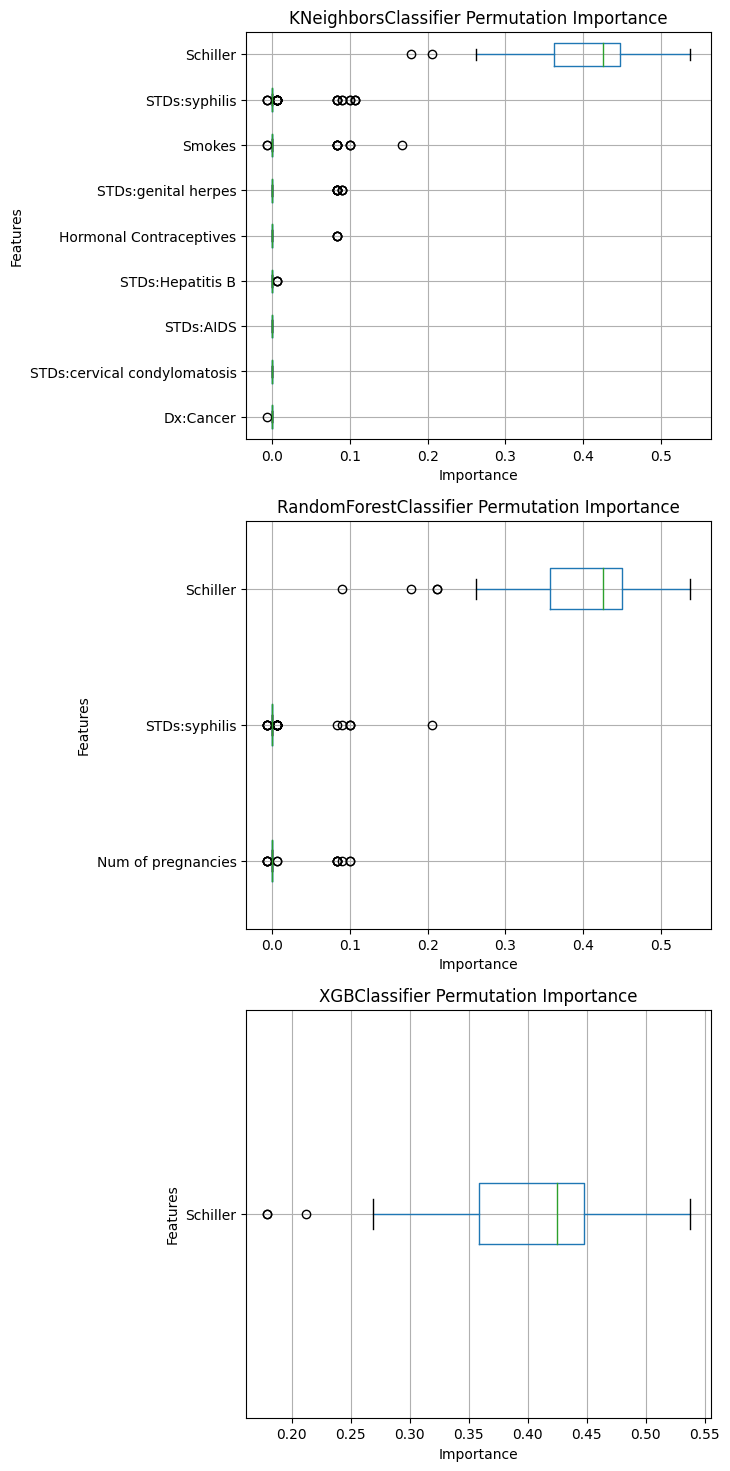

In [36]:
feature_importance(
    [
        (
            KNeighborsClassifier(
                n_neighbors=1,
                metric="cosine",
                weights="uniform",
            ),
            [
                "Smokes",
                "Hormonal Contraceptives",
                "STDs:cervical condylomatosis",
                "STDs:syphilis",
                "STDs:genital herpes",
                "STDs:AIDS",
                "STDs:Hepatitis B",
                "Dx:Cancer",
                "Schiller",
            ],
        ),
        (
            RandomForestClassifier(
                criterion="log_loss",
                max_depth=10,
                n_estimators=30,
            ),
            [
                "Num of pregnancies",
                "STDs:syphilis",
                "Schiller",
            ],
        ),
        (
            XGBClassifier(
                objective="binary:logistic",
                learning_rate=0.1,
                n_estimators=50,
                max_depth=3,
            ),
            [
                "Schiller",
            ],
        ),
    ],
    X,
    y,
    skf,
)

We can see that in all three cases the most relevant attribute was Schiller. Note that this method has not been used as feature selection because with correlated attributes it is not as reliable as the other methods.


## &#160;&#160;&#160;&#160;5.4. Advanced tuning


Finally, we will perform a last hyperparameter optimization to see if it can be further improved. For this, Bayesian optimization will be used instead of grid search.


In [37]:
def advanced_tuning(models, X, y, cv):

    def objective(trial):
        params_trial = dict()
        for param in params:
            type = param[0]
            data = param[1]
            if type == "int":
                params_trial[data[0]] = trial.suggest_int(*data)
            elif type == "float":
                params_trial[data[0]] = trial.suggest_float(*data)
            elif type == "categorical":
                params_trial[data[0]] = trial.suggest_categorical(*data)

        score = cross_val_score(
            model(**params_trial),
            X_selected,
            y,
            n_jobs=-1,
            cv=cv,
            scoring="balanced_accuracy",
        )

        return score.mean()

    for model, params, attributes in models:

        X_selected = X[attributes]

        study = create_study(direction="maximize")
        study.optimize(objective, n_trials=150, n_jobs=-1)

        output = "%s: %.3f with %s" % (
            model.__name__,
            study.best_trial.values[0],
            study.best_trial.params,
        )
        print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))
        plot_optimization_history(study, target_name="Performance")
        plt.title(model.__name__)

    plt.show()

KNeighborsClassifier: 0.932 with {'n_neighbors': 1, 'metric': 'cosine', 'weights':
	'uniform'}
RandomForestClassifier: 0.924 with {'max_depth': 43, 'n_estimators': 231, 'criterion':
	'log_loss'}
XGBClassifier: 0.922 with {'objective': 'binary:logistic', 'learning_rate':
	0.05276467218702017, 'n_estimators': 238, 'max_depth': 2}


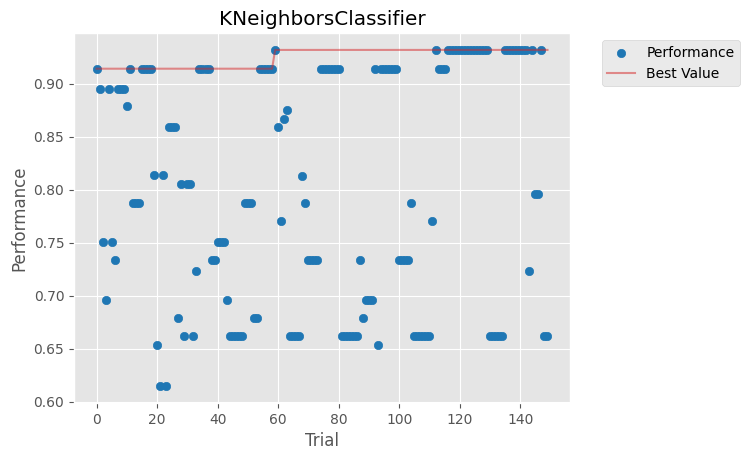

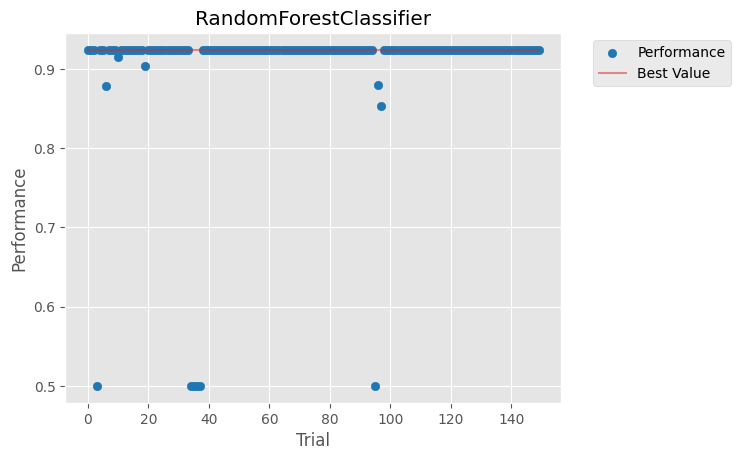

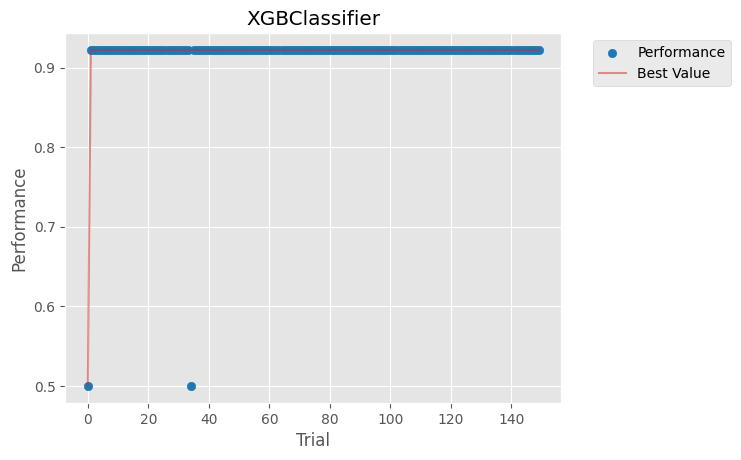

In [38]:
advanced_tuning(
    [
        (
            KNeighborsClassifier,
            [
                ("int", ("n_neighbors", 1, 21)),
                ("categorical", ("metric", ["cosine", "euclidean", "manhattan"])),
                ("categorical", ("weights", ["distance", "uniform"])),
            ],
            [
                "Smokes",
                "Hormonal Contraceptives",
                "STDs:cervical condylomatosis",
                "STDs:syphilis",
                "STDs:genital herpes",
                "STDs:AIDS",
                "STDs:Hepatitis B",
                "Dx:Cancer",
                "Schiller",
            ],
        ),
        (
            RandomForestClassifier,
            [
                ("int", ("max_depth", 1, 50)),
                ("int", ("n_estimators", 1, 500)),
                ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
            ],
            [
                "Num of pregnancies",
                "STDs:syphilis",
                "Schiller",
            ],
        ),
        (
            XGBClassifier,
            [
                ("categorical", ("objective", ["binary:logistic"])),
                ("float", ("learning_rate", 0.01, 0.2)),
                ("int", ("n_estimators", 20, 500)),
                ("int", ("max_depth", 1, 20)),
            ],
            [
                "Schiller",
            ],
        ),
    ],
    X,
    y,
    skf,
)

The results obtained are:

- KNeighborsClassifier: 0.932 with {'n_neighbors': 1, 'metric': 'cosine', 'weights': 'uniform'}
- RandomForestClassifier: 0.924 with {'max_depth': 8, 'n_estimators': 441, 'criterion': 'log_loss'}
- XGBClassifier: 0.922 with {'objective': 'binary:logistic', 'learning_rate': 0.03255651269771115, 'n_estimators': 70, 'max_depth': 14}

Note that we can also see the performance of the different combinations, being in RandomForest and XGBoost stable, so there is probably no better result. On the other hand, we can see that this does not occur in KNN, although, taking into account the extreme hyperparameters (1 single neighbor), it is not believed that there is much room for improvement.

Finally, let's see a table with all the results obtained.

|                  | KNN   | RF.   | XGB   |
| ---------------- | ----- | ----- | ----- |
| Initial          | 0.734 | 0.500 | 0.661 |
| First tuning     | 0.734 | 0.787 | 0.818 |
| Feature selector | 0.932 | 0.924 | 0.922 |
| Second tuning    | 0.932 | 0.924 | 0.922 |

We can see how the best result in the end has not been from the models in which we had the most confidence, but from KNN. Therefore the question may arise, will there be other models that improve this performance? To do so, we will explore deep networks. Note that GBDTs have long been the state of the art for tabular data, so success is not assured considering, moreover, the few instances.


## 6. DNN approaches


## &#160;&#160;&#160;&#160;6.1. Simple Neural Network


First we will start with a simple deep neural network, to see the performance without optimizing the architecture or the hyperparameters, which will be chosen by trial and error. Specifically, it will be composed of linear blocks whose activation will be relu with normalization and dropout.


In [39]:
class LinearReluBlock(nn.Module):

    def __init__(
        self,
        input_size,
        out_size,
        dropout_rate,
    ):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, out_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

    def forward(self, input):
        return self.linear_relu_stack(input)


class SimpleNeuralNetwork(nn.Module):

    def __init__(
        self,
        input_size,
        out_size,
        middle_size=512,
        num_middle_blocks=1,
        skip_connection=False,
        dropout_rate=0.1,
    ):
        super().__init__()
        self.skip_connection = skip_connection

        self.first_block = LinearReluBlock(input_size, middle_size, dropout_rate)

        self.middle_blocks = nn.Sequential()
        for i in range(num_middle_blocks):
            self.middle_blocks.add_module(
                f"Block{i}", LinearReluBlock(middle_size, middle_size, dropout_rate)
            )

        self.last_block = nn.Sequential(
            nn.BatchNorm1d(middle_size),
            nn.Linear(middle_size, out_size),
        )

    def forward(self, input):
        out1 = self.first_block(input)
        out2 = self.middle_blocks(out1)
        if self.skip_connection:
            out2 += out1
        logits = self.last_block(out2)
        return logits

We will also create a class to help us train, evaluate and predict. Note that it will be as generic as possible to serve in this case and in the next one we will see.


In [40]:
class NeuralNetworkTrainer:

    def __init__(
        self,
        model,
        loss_fn,
        optimizer,
        *,
        device=torch.device("cpu"),
    ):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.device = device

        self.mtr_ = None
        self.loss_ = None
        self.vmtr_ = None
        self.vloss_ = None
        self.history_ = {"mtr": [], "loss": [], "vmtr": [], "vloss": []}

    def execute(
        self,
        dataloader,
        *,
        vdataloader=None,
        metric=accuracy_score,
        epochs=5,
        early_stopper=None,
        verbose=1,
    ):
        num_batch = len(dataloader)

        progress_bar = None

        for e in range(1, 1 + epochs):

            if verbose > 0:
                progress_bar = tqdm(total=num_batch, unit="batch", desc=f"Epoch {e}")

            self.__train_one_epoch(dataloader, progress_bar)
            self.mtr_, self.loss_ = self.eval(dataloader, metric, calc_loss=True)
            self.history_["mtr"].append(self.mtr_)
            self.history_["loss"].append(self.loss_)

            if verbose > 0:
                post = {"mtr": f"{self.mtr_:.4f}", "loss": f"{self.loss_:.4f}"}
                progress_bar.set_postfix(**post)

            if vdataloader:
                self.vmtr_, self.vloss_ = self.eval(vdataloader, metric, calc_loss=True)
                self.history_["vmtr"].append(self.vmtr_)
                self.history_["vloss"].append(self.vloss_)

                if verbose > 0:
                    vpost = {"vmtr": f"{self.vmtr_:.4f}", "vloss": f"{self.vloss_:.4f}"}
                    progress_bar.set_postfix(**post, **vpost)

                if early_stopper(self.vloss_):
                    if verbose > -1:
                        if verbose > 0:
                            progress_bar.close()
                        print(f"Early stop at epoch {e}")
                    break

            if verbose > 0:
                progress_bar.close()

        if verbose > -1:
            print(f"Training: mtr={self.mtr_:.4f}, loss={self.loss_:.4f}")
            if vdataloader:
                print(f"Evaluation: vmtr={self.vmtr_:.4f}, vloss={self.vloss_:.4f}")

        if verbose == 2:
            executed_epochs = range(1, e + 1)
            plt.figure(figsize=(6, 6))
            plt.plot(executed_epochs, self.history_["mtr"], label="mtr")
            plt.plot(executed_epochs, self.history_["loss"], label="loss")
            if vdataloader:
                plt.plot(executed_epochs, self.history_["vmtr"], label="vmtr")
                plt.plot(executed_epochs, self.history_["vloss"], label="vloss")
            plt.title("Metric & Loss History")
            plt.legend()
            plt.show()

        return self

    def __train_one_epoch(self, dataloader, progress_bar):
        self.model.train()

        for data in dataloader:
            data = list(map(lambda x: x.to(self.device), data))

            Xs, y = data[:-1], data[-1]

            pred = self.model(*Xs)
            loss = self.loss_fn(pred, y)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if progress_bar:
                progress_bar.update(1)

    def eval(self, dataloader, metric=accuracy_score, calc_loss=False):
        data = self.predict(dataloader, has_target=True, calc_loss=calc_loss)

        y_pred = data[0]
        y_true = data[1]
        loss = data[2] if calc_loss else None

        score = metric(y_true, y_pred)

        res = []
        res.append(score)
        if calc_loss:
            res.append(loss)

        return (*res,)

    def predict(self, dataloader, has_target=False, calc_loss=False, calc_probs=False):
        total_loss = 0.0
        all_ys = []
        all_preds = []

        num_batch = len(dataloader)

        self.model.eval()

        with torch.no_grad():
            for data in dataloader:
                data = list(map(lambda x: x.to(self.device), data))
                if has_target:
                    Xs, y = data[:-1], data[-1]
                else:
                    Xs = data

                preds = self.model(*Xs)
                if calc_probs:
                    all_preds.extend(nn.functional.softmax(preds, dim=1).cpu().numpy())
                else:
                    all_preds.extend(preds.argmax(dim=1).cpu().numpy())

                if has_target:
                    if calc_loss:
                        total_loss += self.loss_fn(preds, y).item()
                    all_ys.extend(y.cpu().numpy())

        res = []
        res.append(np.array(all_preds))
        if has_target:
            res.append(np.array(all_ys))
            if calc_loss:
                res.append(total_loss / num_batch)

        return (*res,)

Also for the realization of the early stop and to avoid over-adjustment, we will make another auxiliary class to the previous one.


In [41]:
class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta

        self.counter = 0
        self.min_vloss = np.inf

    def __call__(self, vloss):
        if vloss < self.min_vloss:
            self.counter = 0
            self.min_vloss = vloss

        elif vloss > (self.min_vloss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True

        return False

First of all, we restore the default settings of matplotlib since optuna modifies them with the previous function.


In [42]:
mpl.rcParams.update(mpl.rcParamsDefault)

We then train and see the specific behavior for the first partition. The hyperparameters have been chosen, as mentioned above, trying to fit the best result.


Epoch 17: 100%|██████████| 49/49 [00:00<00:00, 319.06batch/s, loss=0.3002, mtr=0.9323, vloss=0.1714, vmtr=0.9630]
Early stop at epoch 17
Training: mtr=0.9323, loss=0.3002
Evaluation: vmtr=0.9630, vloss=0.1714


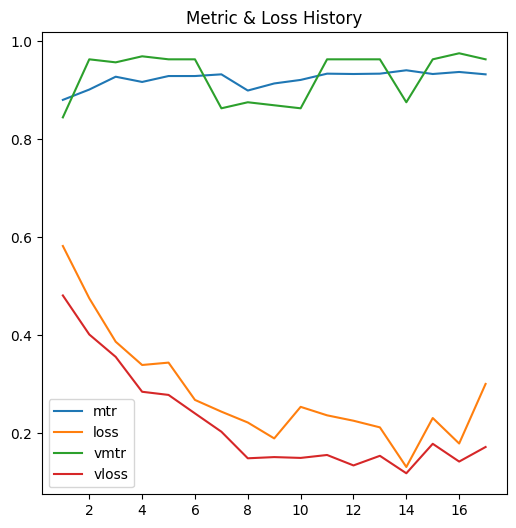

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
epochs = 150
learning_rate = 1e-2
early_stopper_args = {"patience": 3, "min_delta": 1e-2}

model = SimpleNeuralNetwork(X.shape[1], 2, 64, 1, True, 0.15).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

idx_train, idx_test = next(skf.split(X, y))

X_train, X_test, y_train, y_test = (
    X.iloc[idx_train],
    X.iloc[idx_test],
    y.iloc[idx_train],
    y.iloc[idx_test],
)

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

net = NeuralNetworkTrainer(
    model,
    loss_fn,
    optimizer,
    device=device,
).execute(
    train_dataloader,
    vdataloader=test_dataloader,
    metric=balanced_accuracy_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

We can see how as the loss in the test set increases, the execution is stopped so that there is no overfitting. Note that there may be many peaks in the metric due to the imbalance in the data set and, therefore, the importance is taken by the positive instances.

In addition to this metric, which is the one used throughout the notebook, we can also use the roc curve, which is also widely used in neural networks.


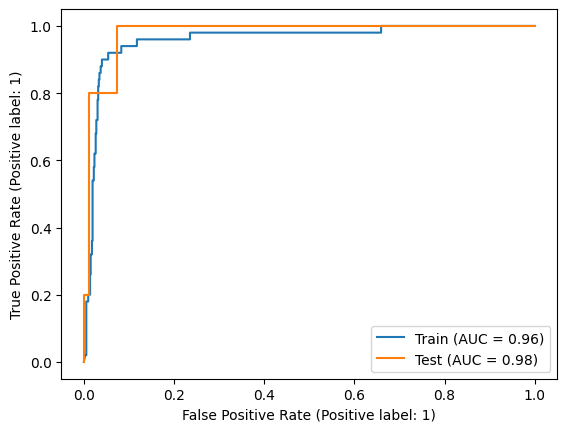

In [44]:
train_preds, train_y = net.predict(train_dataloader, has_target=True, calc_probs=True)
test_preds, test_y = net.predict(test_dataloader, has_target=True, calc_probs=True)


positive_train_preds = train_preds[:, 1]
positive_test_preds = test_preds[:, 1]

_, ax = plt.subplots(nrows=1, ncols=1)
RocCurveDisplay.from_predictions(train_y, positive_train_preds, ax=ax, name="Train")
RocCurveDisplay.from_predictions(test_y, positive_test_preds, ax=ax, name="Test")
plt.show()

As before, we can also see the importance of attributes.


100%|██████████| 30/30 [01:41<00:00,  3.38s/it]


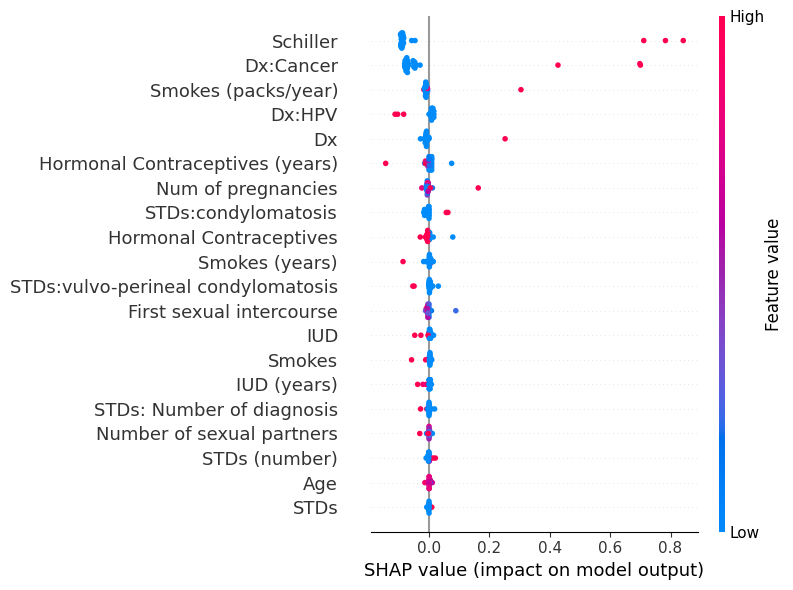

In [45]:
predict = lambda input: net.predict(
    DataLoader(
        TensorDataset(torch.tensor(input, dtype=torch.float)),
        batch_size=batch_size,
    ),
    has_target=False,
    calc_loss=False,
    calc_probs=False,
)[0]


data = X_test[:30]
explainer = shap.KernelExplainer(predict, data)
shap_values = explainer.shap_values(data)
shap.summary_plot(shap_values, data, X.columns, plot_size=(8, 6))

What this graph tells us is that, again, the most influential attribute is “Schiller”, so that if its value is high, i.e., it is positive, then it will influence the model such that the output will probably also be positive, while if its value is low, the output will probably also be negative. Note that not all attributes are listed because some are of no interest.

Finally, we will check with all the folds in order to make a fairer comparison with the results of the classic models.


In [46]:
metric, loss, vmetric, vloss = [], [], [], []

for i, (idx_train, idx_test) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}: -----------------")

    model = SimpleNeuralNetwork(X.shape[1], 2, 64, 1, True, 0.15).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    X_train, X_test, y_train, y_test = (
        X.iloc[idx_train],
        X.iloc[idx_test],
        y.iloc[idx_train],
        y.iloc[idx_test],
    )

    X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float)
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    net = NeuralNetworkTrainer(
        model,
        loss_fn,
        optimizer,
        device=device,
    ).execute(
        train_dataloader,
        vdataloader=test_dataloader,
        metric=balanced_accuracy_score,
        epochs=epochs,
        early_stopper=EarlyStopper(**early_stopper_args),
        verbose=0,
    )

    metric.append(net.mtr_)
    loss.append(net.loss_)
    vmetric.append(net.vmtr_)
    vloss.append(net.vloss_)


print()
print(f"Mean metric across folds: {sum(metric) / len(metric):.4f}")
print(f"Mean loss across folds: {sum(loss) / len(loss):.4f}")
print(f"Mean vmetric across folds: {sum(vmetric) / len(vmetric):.4f}")
print(f"Mean vloss across folds: {sum(vloss) / len(vloss):.4f}")

Fold 1: -----------------
Early stop at epoch 16
Training: mtr=0.9348, loss=0.1175
Evaluation: vmtr=0.7815, vloss=0.1488
Fold 2: -----------------
Early stop at epoch 123
Training: mtr=0.9196, loss=0.0841
Evaluation: vmtr=0.9938, vloss=0.0386
Fold 3: -----------------
Early stop at epoch 14
Training: mtr=0.8596, loss=0.1494
Evaluation: vmtr=0.4815, vloss=0.2216
Fold 4: -----------------
Early stop at epoch 59
Training: mtr=0.8774, loss=0.1077
Evaluation: vmtr=0.6604, vloss=0.0702
Fold 5: -----------------
Early stop at epoch 4
Training: mtr=0.9111, loss=0.2562
Evaluation: vmtr=0.8854, vloss=17.0868
Fold 6: -----------------
Early stop at epoch 30
Training: mtr=0.9270, loss=0.1022
Evaluation: vmtr=0.5771, vloss=0.1625
Fold 7: -----------------
Early stop at epoch 44
Training: mtr=0.8943, loss=0.0939
Evaluation: vmtr=0.9104, vloss=0.0673
Fold 8: -----------------
Early stop at epoch 4
Training: mtr=0.9294, loss=0.3411
Evaluation: vmtr=0.9375, vloss=53.0579
Fold 9: -----------------
Early

Again, we note the results as they may vary somewhat due to randomization:

- Mean metric across folds: 0.9061
- Mean loss across folds: 0.1846
- Mean vmetric across folds: 0.8505
- Mean vloss across folds: 7.8249

Therefore, we have obtained a yield of approximately 85% among all the folds. For not having worried too much about the architecture and hyperparameters, the results are not too bad either.


## &#160;&#160;&#160;&#160;6.2. TabTransformer


To try to improve them, we are going to implement a type of architecture that has already been studied and that may give better results, the TabTransformers, which aim to relate categorical attributes (since there will be some values that are more related to others). To do this, we will first undo the one-hot coding and indicate it as a single column for the two categorical attributes mentioned at the beginning of the notebook.


In [47]:
std_col_names = [
    "STDs:condylomatosis",
    "STDs:cervical condylomatosis",
    "STDs:vaginal condylomatosis",
    "STDs:vulvo-perineal condylomatosis",
    "STDs:syphilis",
    "STDs:pelvic inflammatory disease",
    "STDs:genital herpes",
    "STDs:molluscum contagiosum",
    "STDs:AIDS",
    "STDs:HIV",
    "STDs:Hepatitis B",
    "STDs:HPV",
]

dx_col_names = [
    "Dx:Cancer",
    "Dx:CIN",
    "Dx:HPV",
]

for cat_col in std_col_names + dx_col_names:
    X[cat_col] = X[cat_col].apply(lambda x: 0 if x == X[cat_col].min() else 1)

X["STDs:all"] = list(
    map(lambda x: int("".join(x), 2), X[std_col_names].to_numpy().astype(str))
)
X.drop(std_col_names, axis=1, inplace=True)


X["Dx:all"] = list(
    map(lambda x: int("".join(x), 2), X[dx_col_names].to_numpy().astype(str))
)
X.drop(dx_col_names, axis=1, inplace=True)

In addition, we need to separate these two attributes from the rest when applying the model, so we made an auxiliary dataset class specifically for this case.


In [48]:
class SplitDataset(Dataset):

    def __init__(self, X, y, cat_col_names):
        X = X.copy()
        self.X_cat = X.loc[:, cat_col_names].to_numpy().astype(np.int64)
        self.X_num = X.drop(cat_col_names, axis=1).to_numpy().astype(np.float32)
        self.y = y.to_numpy()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

Finally, the TabTransformer.


In [49]:
class TabTransformer(nn.Module):

    def __init__(
        self,
        n_numerical,
        emb_categorical,
        out_size,
        n_heads=1,
        n_transformer_layers=1,
        middle_size=128,
        num_middle_blocks=1,
        skip_connection=False,
        dropout_rate=0.1,
    ):
        super().__init__()
        n_embedding_sizes = sum(emb_size for _, emb_size in emb_categorical)

        self.num_bn = nn.BatchNorm1d(n_numerical)

        self.embeddings = nn.ModuleList(
            [
                nn.Embedding(num_features, emb_size)
                for num_features, emb_size in emb_categorical
            ]
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=n_embedding_sizes, nhead=n_heads),
            num_layers=n_transformer_layers,
        )

        self.simple_net = SimpleNeuralNetwork(
            n_embedding_sizes + n_numerical,
            out_size,
            middle_size,
            num_middle_blocks,
            skip_connection,
            dropout_rate,
        )

    def forward(self, cat_inputs, num_inputs):
        x1 = self.num_bn(num_inputs)

        x2 = [emb(cat_inputs[:, i]) for i, emb in enumerate(self.embeddings)]
        x2 = torch.cat(x2, dim=1)
        x2 = self.transformer(x2)

        x = torch.cat([x1, x2], dim=1)

        logits = self.simple_net(x)

        return logits

We look again at the specific case of a single fold.


Epoch 15: 100%|██████████| 49/49 [00:00<00:00, 158.35batch/s, loss=0.1475, mtr=0.9248, vloss=0.2101, vmtr=0.9691]
Early stop at epoch 15
Training: mtr=0.9248, loss=0.1475
Evaluation: vmtr=0.9691, vloss=0.2101


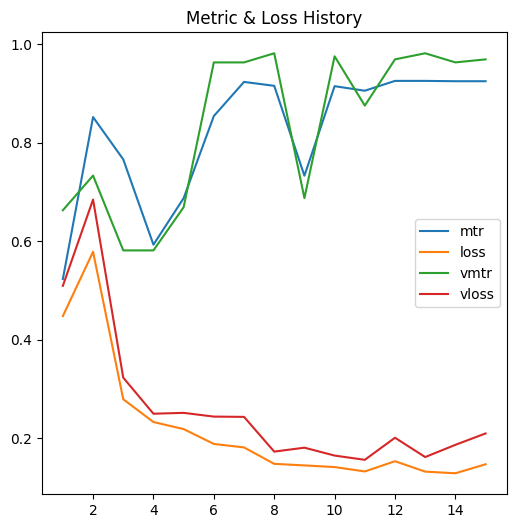

In [50]:
num_per_cat = {"STDs:all": 12, "Dx:all": 3}
cat_names = num_per_cat.keys()
cat_num = num_per_cat.values()

n_numerical = 16
emb_categorical = [(2**n, min(50, (2**n + 1) // 2)) for n in cat_num]
n_targets = 2

batch_size = 16
epochs = 150
learning_rate = 1e-2
early_stopper_args = {"patience": 3, "min_delta": 1e-2}

model = TabTransformer(
    n_numerical,
    emb_categorical,
    n_targets,
    n_heads=2,
    n_transformer_layers=1,
    middle_size=64,
    num_middle_blocks=1,
    skip_connection=False,
    dropout_rate=0.15,
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

idx_train, idx_test = next(skf.split(X, y))

X_train, X_test, y_train, y_test = (
    X.iloc[idx_train],
    X.iloc[idx_test],
    y.iloc[idx_train],
    y.iloc[idx_test],
)

train_data = SplitDataset(X_train, y_train, cat_names)
test_data = SplitDataset(X_test, y_test, cat_names)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


net = NeuralNetworkTrainer(
    model,
    loss_fn,
    optimizer,
    device=device,
).execute(
    train_dataloader,
    vdataloader=test_dataloader,
    metric=balanced_accuracy_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

It is similar again, so we will check with all the folds to see if the results have been improved.


In [51]:
metric, loss, vmetric, vloss = [], [], [], []

for i, (idx_train, idx_test) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}: -----------------")

    model = TabTransformer(
        n_numerical,
        emb_categorical,
        n_targets,
        n_heads=2,
        n_transformer_layers=1,
        middle_size=64,
        num_middle_blocks=1,
        skip_connection=False,
        dropout_rate=0.15,
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    X_train, X_test, y_train, y_test = (
        X.iloc[idx_train],
        X.iloc[idx_test],
        y.iloc[idx_train],
        y.iloc[idx_test],
    )

    train_data = SplitDataset(X_train, y_train, cat_names)
    test_data = SplitDataset(X_test, y_test, cat_names)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    net = NeuralNetworkTrainer(
        model,
        loss_fn,
        optimizer,
        device=device,
    ).execute(
        train_dataloader,
        vdataloader=test_dataloader,
        metric=balanced_accuracy_score,
        epochs=epochs,
        early_stopper=EarlyStopper(**early_stopper_args),
        verbose=0,
    )

    loss.append(net.loss_)
    metric.append(net.mtr_)
    vloss.append(net.vloss_)
    vmetric.append(net.vmtr_)

print()
print(f"Mean metric across folds: {sum(metric) / len(metric):.4f}")
print(f"Mean loss across folds: {sum(loss) / len(loss):.4f}")
print(f"Mean vmetric across folds: {sum(vmetric) / len(vmetric):.4f}")
print(f"Mean vloss across folds: {sum(vloss) / len(vloss):.4f}")

Fold 1: -----------------
Early stop at epoch 20
Training: mtr=0.9148, loss=0.1750
Evaluation: vmtr=0.9753, vloss=0.1637
Fold 2: -----------------
Early stop at epoch 34
Training: mtr=0.9385, loss=0.1680
Evaluation: vmtr=0.9877, vloss=0.1015
Fold 3: -----------------
Early stop at epoch 14
Training: mtr=0.9306, loss=0.1494
Evaluation: vmtr=0.8691, vloss=0.2239
Fold 4: -----------------
Early stop at epoch 76
Training: mtr=0.7013, loss=0.0931
Evaluation: vmtr=0.6667, vloss=0.0654
Fold 5: -----------------
Early stop at epoch 11
Training: mtr=0.9338, loss=0.1481
Evaluation: vmtr=0.7312, vloss=0.1815
Fold 6: -----------------
Early stop at epoch 21
Training: mtr=0.9324, loss=0.1506
Evaluation: vmtr=0.8979, vloss=0.1889
Fold 7: -----------------
Early stop at epoch 20
Training: mtr=0.9324, loss=0.1110
Evaluation: vmtr=0.9104, vloss=0.1375
Fold 8: -----------------
Early stop at epoch 17
Training: mtr=0.9243, loss=0.1285
Evaluation: vmtr=0.8917, vloss=0.2104
Fold 9: -----------------
Early 

The obtained results are:

- Mean metric across folds: 0.9321
- Mean loss across folds: 0.1407
- Mean vmetric across folds: 0.9166
- Mean vloss across folds: 0.1674

Therefore, we have significantly improved the results to almost equal those of the classic models.

Finally, we are going to adjust some of the hyperparameters to try to improve them a little more. To do this, we use optuna again, but without the need to define a function that iterates over all the models, since in this case we only have one.


In [52]:
def objective(trial):
    vmetric = []

    for fold, (idx_train, idx_test) in enumerate(skf.split(X, y)):

        batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
        lr = trial.suggest_float("lr", 1e-5, 1e-1)

        model = TabTransformer(
            n_numerical,
            emb_categorical,
            n_targets,
            n_heads=trial.suggest_categorical("n_heads", [2, 3]),
            n_transformer_layers=trial.suggest_int("n_transf", 1, 5),
            middle_size=trial.suggest_int("middle_size", 16, 512, step=16),
            num_middle_blocks=trial.suggest_int("num_middle_block", 0, 5),
            skip_connection=trial.suggest_categorical("skip", [False, True]),
            dropout_rate=trial.suggest_float("dropout_rate", 0.0, 0.9),
        ).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        X_train, X_test, y_train, y_test = (
            X.iloc[idx_train],
            X.iloc[idx_test],
            y.iloc[idx_train],
            y.iloc[idx_test],
        )

        traind = SplitDataset(X_train, y_train, cat_names)
        testd = SplitDataset(X_test, y_test, cat_names)

        train_dataloader = DataLoader(traind, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(testd, batch_size=batch_size, shuffle=False)

        net = NeuralNetworkTrainer(
            model,
            loss_fn,
            optimizer,
            device=device,
        ).execute(
            train_dataloader,
            vdataloader=test_dataloader,
            metric=balanced_accuracy_score,
            epochs=epochs,
            early_stopper=EarlyStopper(**early_stopper_args),
            verbose=-1,
        )

        vmetric.append(net.vmtr_)

        partial_score = sum(vmetric) / len(vmetric)
        trial.report(partial_score, fold)

        if trial.should_prune():
            raise TrialPruned()

    score = sum(vmetric) / len(vmetric)
    return score

We run the optimization.


Best trial: 31. Best value: 0.925502: 100%|██████████| 50/50 [22:43<00:00, 27.27s/it]
TabTransformer: 0.926 with {'batch_size': 16, 'lr': 0.009176864997087893, 'n_heads': 3,
	'n_transf': 3, 'middle_size': 64, 'num_middle_block': 1, 'skip': False, 'dropout_rate':
	0.36947527646732836}


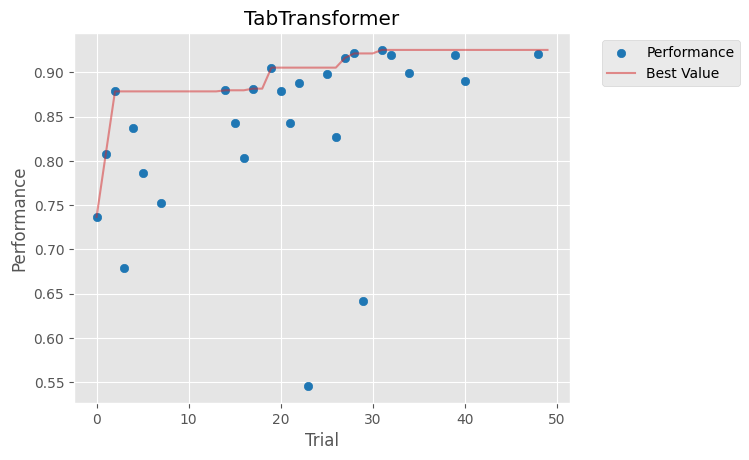

In [53]:
study = create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

output = "TabTransformer: %.3f with %s" % (
    study.best_trial.values[0],
    study.best_trial.params,
)
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))
plot_optimization_history(study, target_name="Performance")
plt.title("TabTransformer")
plt.show()

The result is:

- TabTransformer: 0.927 with {'batch_size': 16, 'lr': 0.007061484017218578, 'n_heads': 2, 'n_transf': 2, 'middle_size': 48, 'num_middle_block': 2, 'skip': False, 'dropout_rate': 0.4429833457720564}

Therefore, we have managed to improve the results a little, but without improving KNN.


## 7. Final results


The final results of predicting biopsy taking into account the Schiller test without Cytology and Hinselmann (in addition to all other attributes) are:

|                   | KNN   | RF.   | XGB   | TabTr. |
| ----------------- | ----- | ----- | ----- | ------ |
| Balanced accuracy | 0.932 | 0.924 | 0.922 | 0.927  |
